В рамках домашнего задания обучите нейронную сеть для решения задачи классификации или регрессии. Рассмотрите возможности модификации архитектуры нейронной сети и настройку различных гиперпараметров. Покажите результат решения поставленной задачи.

In [26]:
import torch
import torch.nn as nn
import torchvision as tv

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

from tqdm import tqdm

trans = tv.transforms.Compose([
    tv.transforms.GaussianBlur(kernel_size=5),
    tv.transforms.ToTensor()
])

ds_mnist = tv.datasets.MNIST('./datasets', download=True, transform=trans)

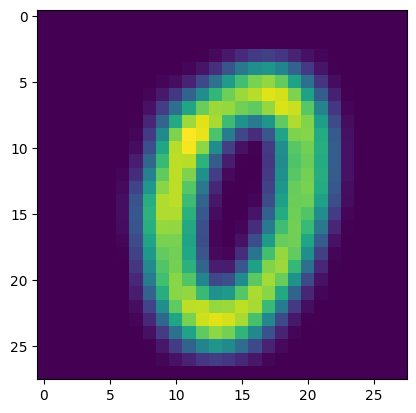

In [27]:
ds_mnist[1000][0].numpy()[0]
plt.imshow(ds_mnist[1000][0].numpy()[0])

In [28]:
batch_size = 16
mnist_train, mnist_test = torch.utils.data.random_split(ds_mnist, [0.6, 0.4])
dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
dataloader_test = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [29]:
class Neural_numbers(nn.Module):
    def __init__(self):
        super().__init__()

        self.flat = nn.Flatten()
        self.linear1 = nn.Linear(28*28, 100)
        self.linear2 = nn.Linear(100, 10)
        self.act = nn.ReLU()

    def forward(self, x): 
        out = self.flat(x)
        out = self.linear1(out)
        out = self.act(out)
        out = self.linear2(out)

        return out

In [30]:
model = Neural_numbers()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.9)

In [31]:
def accuracy(pred, label):
    answer = nn.functional.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
    return answer.mean()

In [32]:
import torch.nn.functional as F
from sklearn.metrics import f1_score

def get_pred_num(pred):
    return F.softmax(pred, dim=None).argmax(axis=1)

class F1:
    def __init__(self) -> None:
        self.arr_pred = []
        self.arr_label = []
    def push_pred(self, val) -> None:
        self.arr_pred.append(get_pred_num(val))
    def push_label(self, val) -> None:
        self.arr_label.append(get_pred_num(val))
    def clear(self) -> None:
        self.arr_pred.clear()
        self.arr_label.clear()
    def score(self):
        label_cc = np.concatenate(self.arr_label)
        pred_cc = np.concatenate(self.arr_pred)
        return f1_score(label_cc, pred_cc, average="macro")

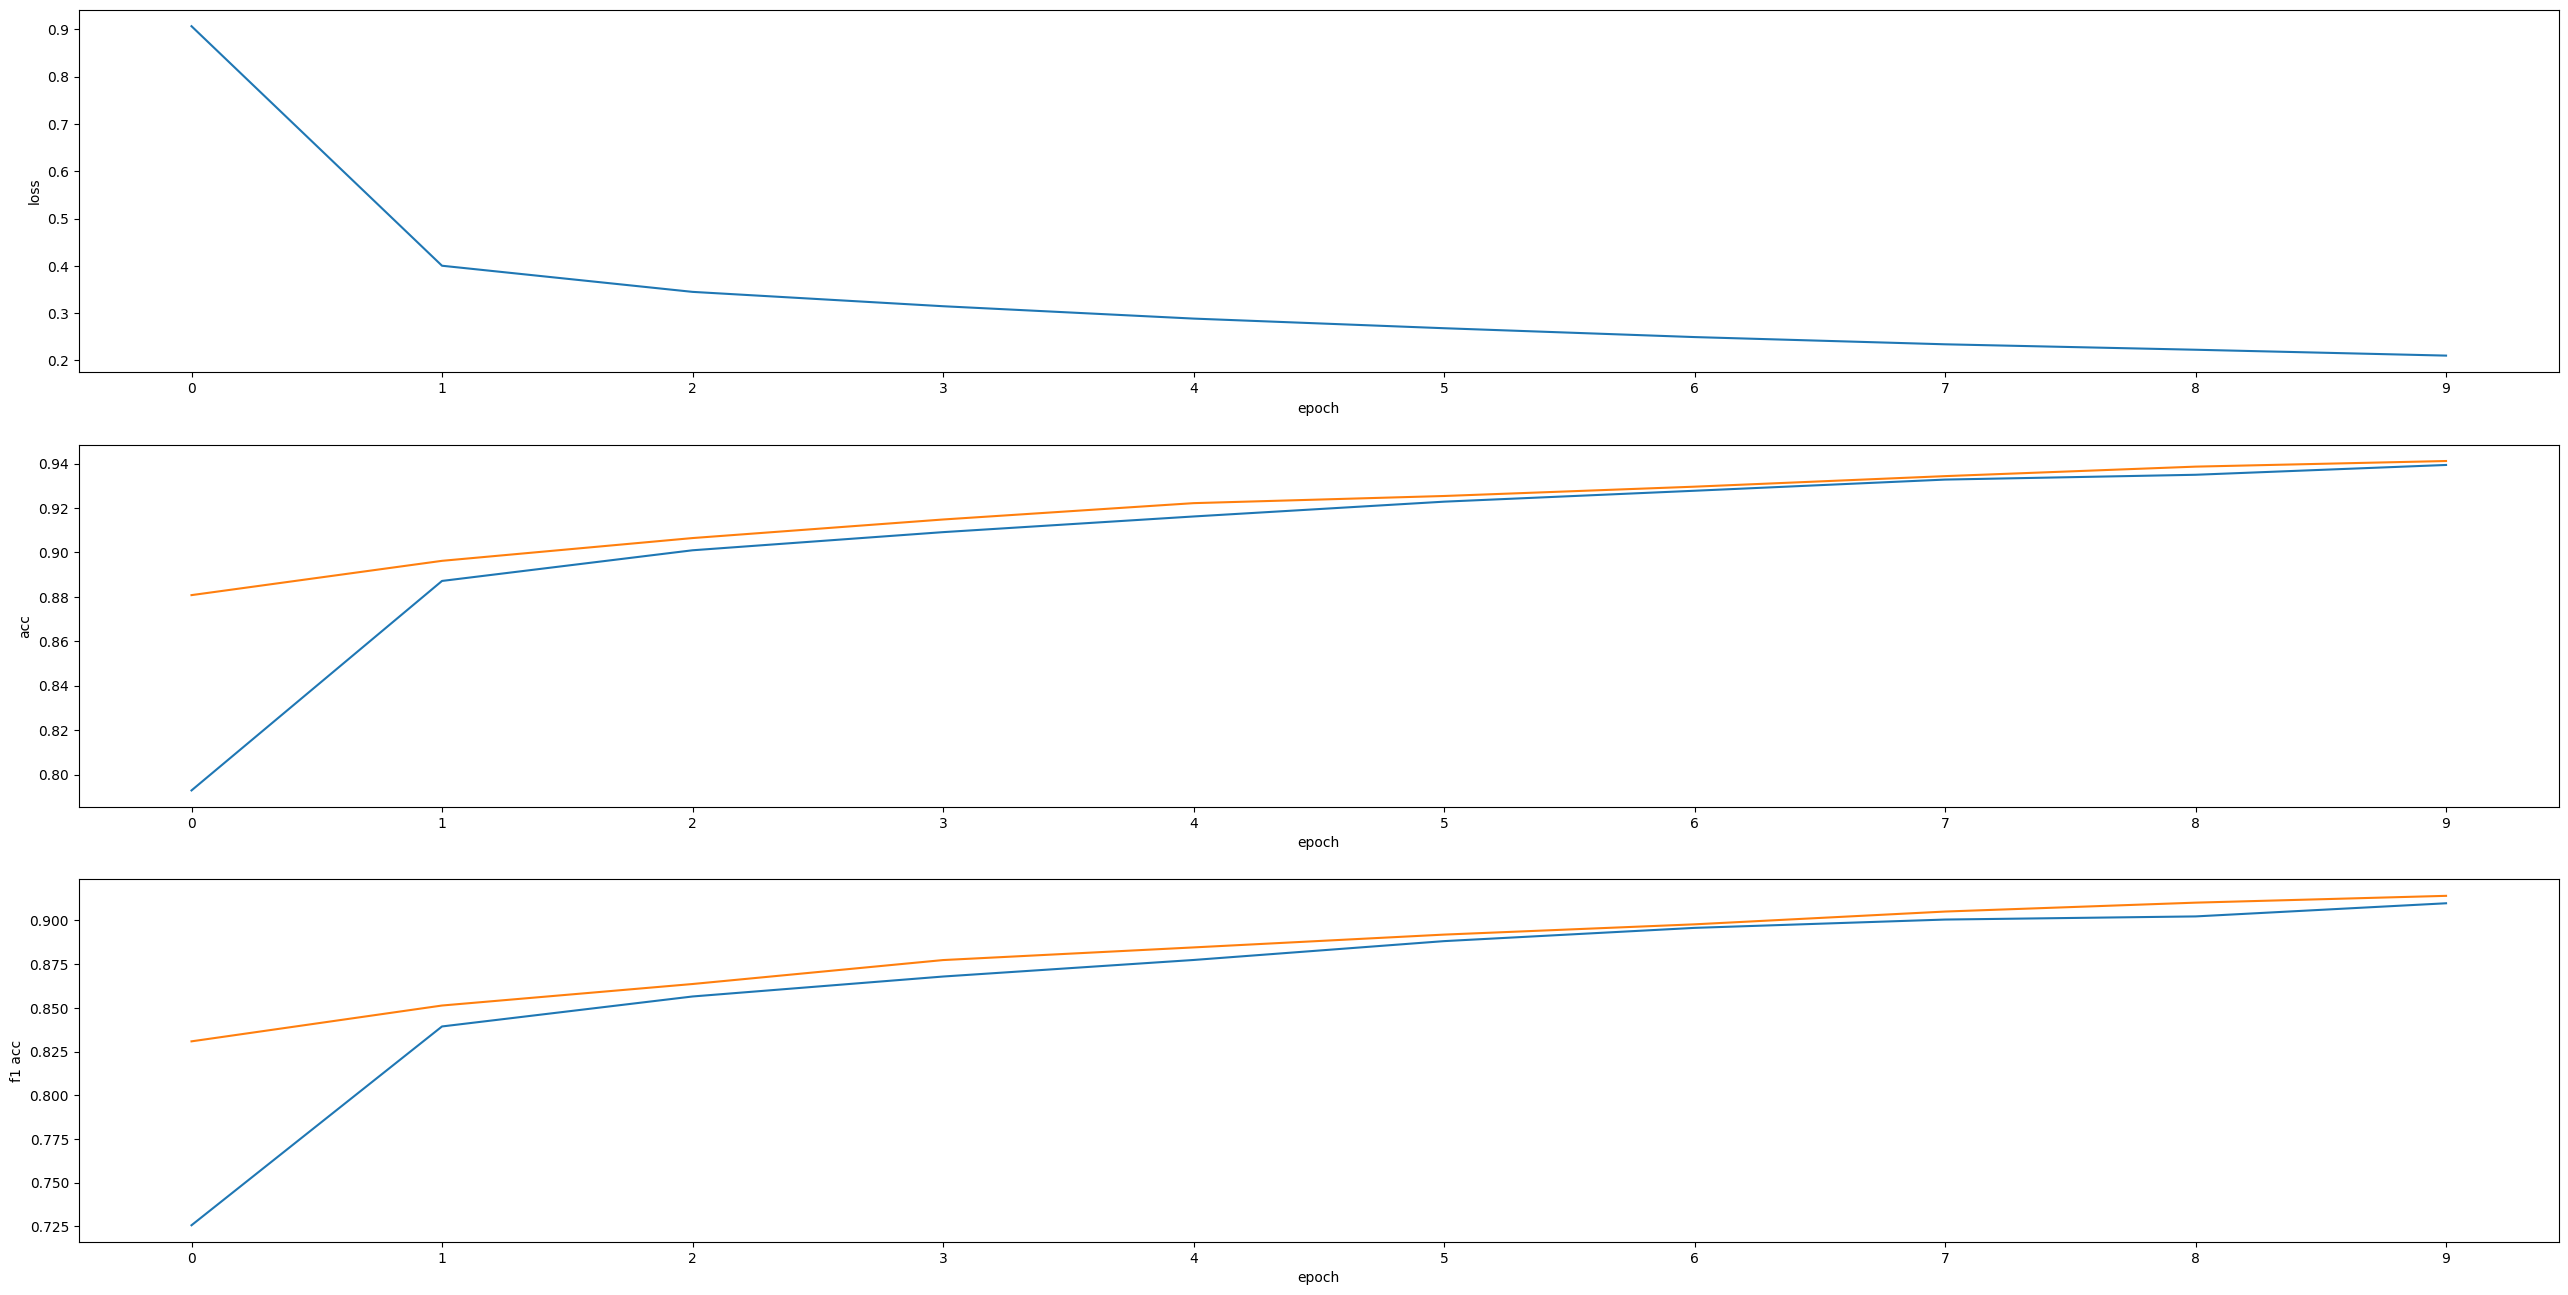

In [33]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

epochs = 10

loss_arr = []
acc_val_arr = []
acc_val_test_arr = []

f1_train = F1()
f1_test = F1()

f1_train_score = []
f1_test_score = []

for epoch in range(epochs):
    loss_val = 0
    acc_val = 0
    f1_train_val = 0
    f1_test_val = 0

    for img, label in (pbar := tqdm(dataloader)):
        optimizer.zero_grad()

        label = F.one_hot(label, 10).float()
        pred = model(img)

        loss = loss_fn(pred, label)

        loss.backward()
        loss_item = loss.item()
        loss_val += loss_item

        optimizer.step()

        acc_current = accuracy(pred, label)
        acc_val += acc_current

        f1_train.push_pred(pred)
        f1_train.push_label(label)

        f1_train_curr = f1_train.score()
        f1_train_val += f1_train_curr

        pbar.set_description(f'loss: {loss_item:.5f}\ accuracy: {acc_current:.3f},f1_score = {f1_train_curr:.3f}')

        f1_train.clear()

    print(loss_val/len(dataloader))
    print(acc_val/len(dataloader))

    acc_val_test = 0
    for img, label in (pbar := tqdm(dataloader)):
        label = F.one_hot(label, 10).float()
        pred = model(img)
        acc_val_test += accuracy(pred, label)

        f1_test.push_pred(pred)
        f1_test.push_label(label)

        f1_test_curr = f1_test.score()
        f1_test_val += f1_test_curr

        f1_test.clear()

    print(acc_val_test/len(dataloader))

    print(f1_train_val/len(dataloader))
    print(f1_test_val/len(dataloader))

    loss_arr.append(loss_val/len(dataloader))
    acc_val_arr.append(acc_val/len(dataloader))
    acc_val_test_arr.append(acc_val_test/len(dataloader))
    f1_train_score.append(f1_train_val/len(dataloader))
    f1_test_score.append(f1_test_val/len(dataloader))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(32, 16))

y = np.arange(epoch + 1)

ax1.plot(y, loss_arr, label='loss_arr')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_xticks(range(0, epochs))
ax2.plot(y, acc_val_arr, label='acc_val_arr')
ax2.plot(y, acc_val_test_arr, label='acc_val_test_arr')
ax2.set_xlabel('epoch')
ax2.set_ylabel('acc')
ax2.set_xticks(range(0, epochs))
ax3.plot(y, f1_train_score, label='f1_train_score')
ax3.plot(y, f1_test_score, label='f1_test_score')
ax3.set_xlabel('epoch')
ax3.set_ylabel('f1 acc')
ax3.set_xticks(range(0, epochs))

ax1.relim()
ax1.autoscale_view()

ax2.relim()
ax2.autoscale_view()

ax3.relim()
ax3.autoscale_view()

clear_output()
plt.show()
